<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


In the following notebook, we aims to develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types.

## <b>1 <span style='color:#e61227'>|</span> reuirements and libraries</b>

Feel free to add any other library you need.


In [4]:
!pip install split-folders
!pip install torch-summary

In [6]:
!pip install torchvision

  Using cached torchvision-0.20.0-cp311-cp311-win_amd64.whl.metadata (6.2 kB)
  Using cached torch-2.5.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torchvision-0.20.0-cp311-cp311-win_amd64.whl (1.6 MB)
Using cached torch-2.5.0-cp311-cp311-win_amd64.whl (203.1 MB)
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   -------------------------------------

  You can safely remove it manually.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange
from tqdm import tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

## <b>2 <span style='color:#e61227'>|</span> Dataset</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2.1 |</span></b> Download and load Dataset</b></p>
</div>

In [2]:
! gdown 1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
! unzip brain.zip

Downloading...
From (original): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
From (redirected): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh&confirm=t&uuid=0d0a47f8-09f4-4a5e-aaaf-322d0d458f95
To: F:\Fatemeh\Education\Master\Medical\IABI_HW2\brain.zip

  0%|          | 0.00/111M [00:00<?, ?B/s]
  0%|          | 524k/111M [00:04<15:22, 120kB/s]
  1%|          | 1.05M/111M [00:08<14:55, 123kB/s]
  1%|1         | 1.57M/111M [00:12<15:00, 122kB/s]
  2%|1         | 2.10M/111M [00:17<15:11, 120kB/s]
  2%|2         | 2.62M/111M [00:21<15:22, 118kB/s]
  3%|2         | 3.15M/111M [00:26<15:23, 117kB/s]
  3%|3         | 3.67M/111M [00:30<15:07, 119kB/s]
  4%|3         | 4.19M/111M [00:35<14:59, 119kB/s]
  4%|4         | 4.72M/111M [00:39<14:55, 119kB/s]
  5%|4         | 5.24M/111M [00:44<15:32, 114kB/s]
  5%|5         | 5.77M/111M [00:51<17:58, 98.0kB/s]
  6%|5         | 6.29M/111M [00:57<18:17, 95.8kB/s]
  6%|6         | 6.82M/111M [01:05<20:59, 83.0kB/s]

## <b>3 <span style='color:#e61227'>|</span> Data Preparation </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3.1 |</span></b> Splitting Dataset</b></p>
</div>

- We need to evaluate the model on validation datasets to track the model's performance during training. Then, We use 20% of the dataset for the **Validation set** and use the rest as the **Training set**, so we have an **80/20** split!

In [2]:
# Dataset Path

data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

In [3]:
# define transformation
# transform images to (256, 256) and normalize them
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),  
        transforms.RandomVerticalFlip(p=0.5),   
        transforms.RandomRotation(degrees=[-30.0, 30.0], interpolation=transforms.InterpolationMode.NEAREST, expand=False, fill=0),  
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
   ]
)

## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b>

In [4]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [5]:
from PIL import Image

def plot_images(images: list[np.ndarray], titles=[]):
    plt.figure(figsize=(35, 10))
    for i in range(len(images)):
        plt.subplot(2, len(images)//2, i+1)
        if len(titles) > i:
            plt.title(titles[i],fontsize=20)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

    plt.show()

def load_image(file_path):
    with Image.open(file_path) as img:
        return img.copy() 

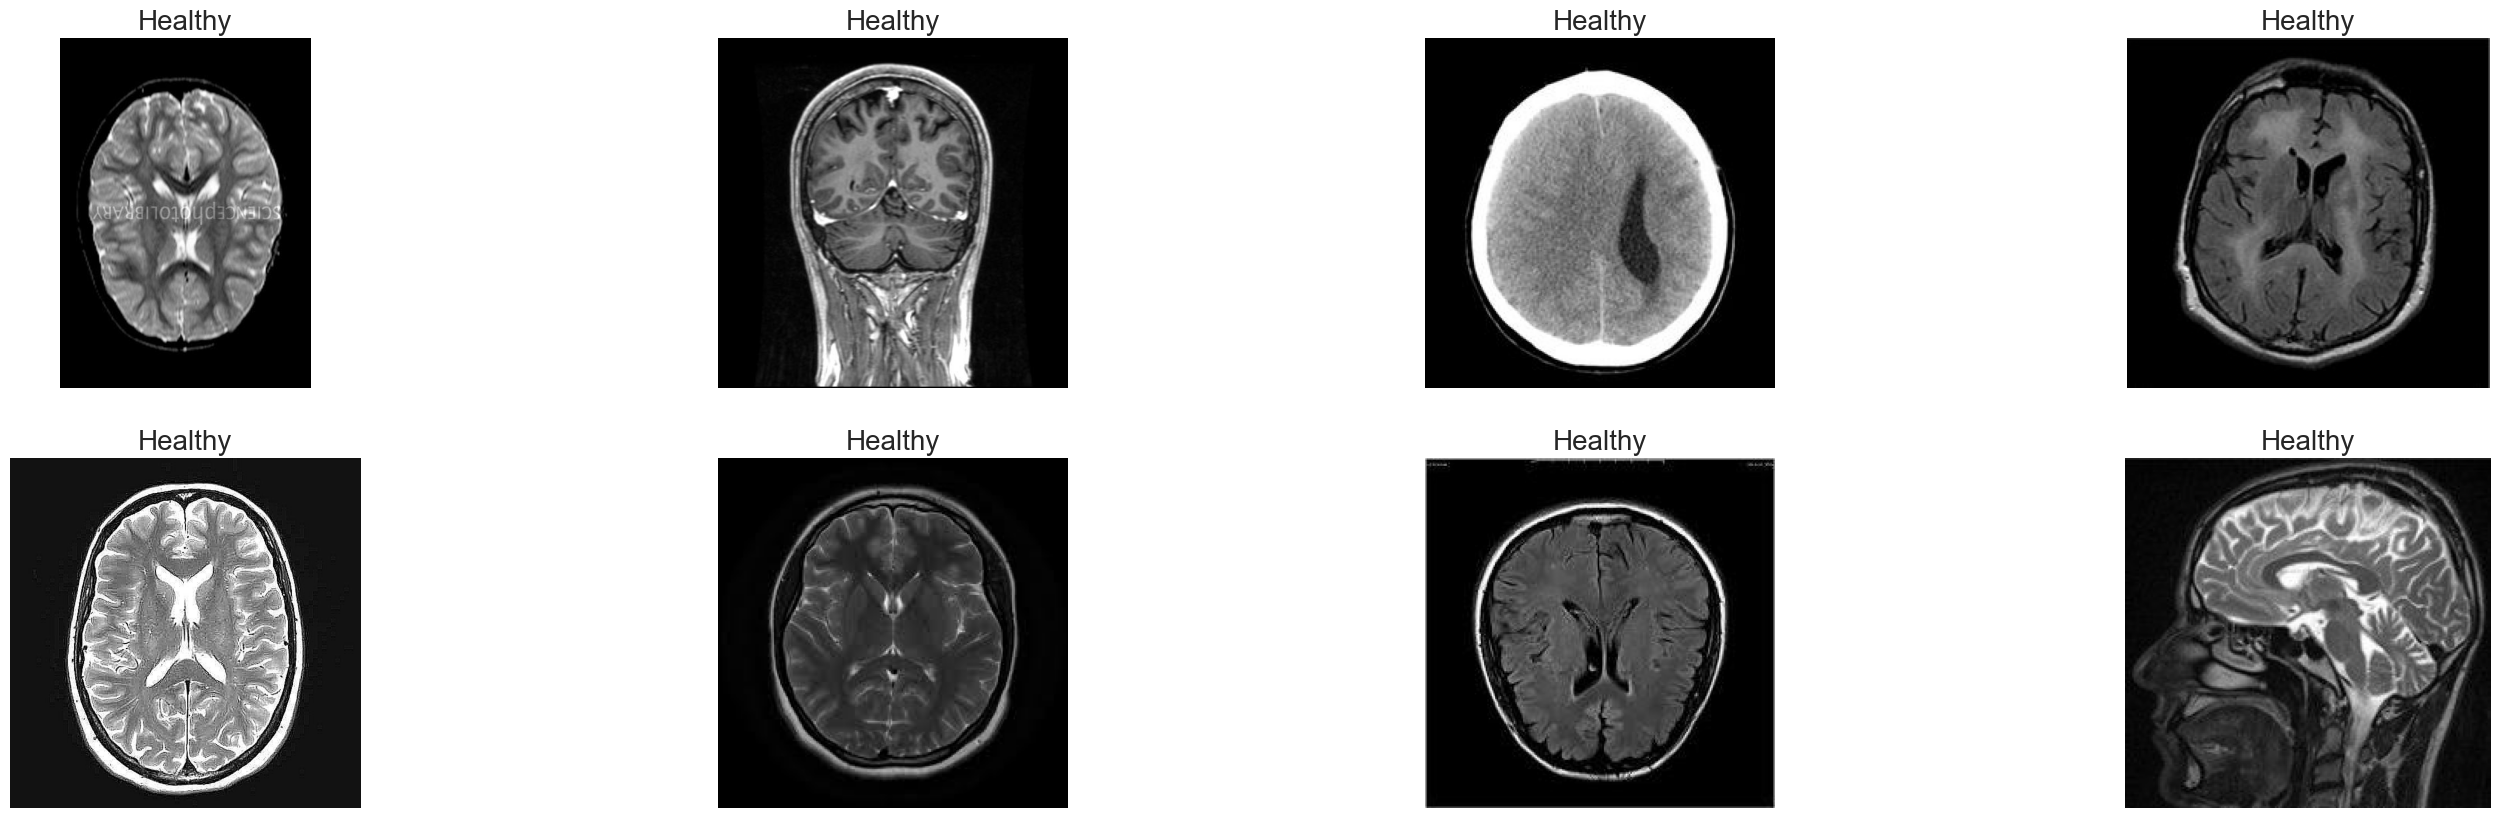

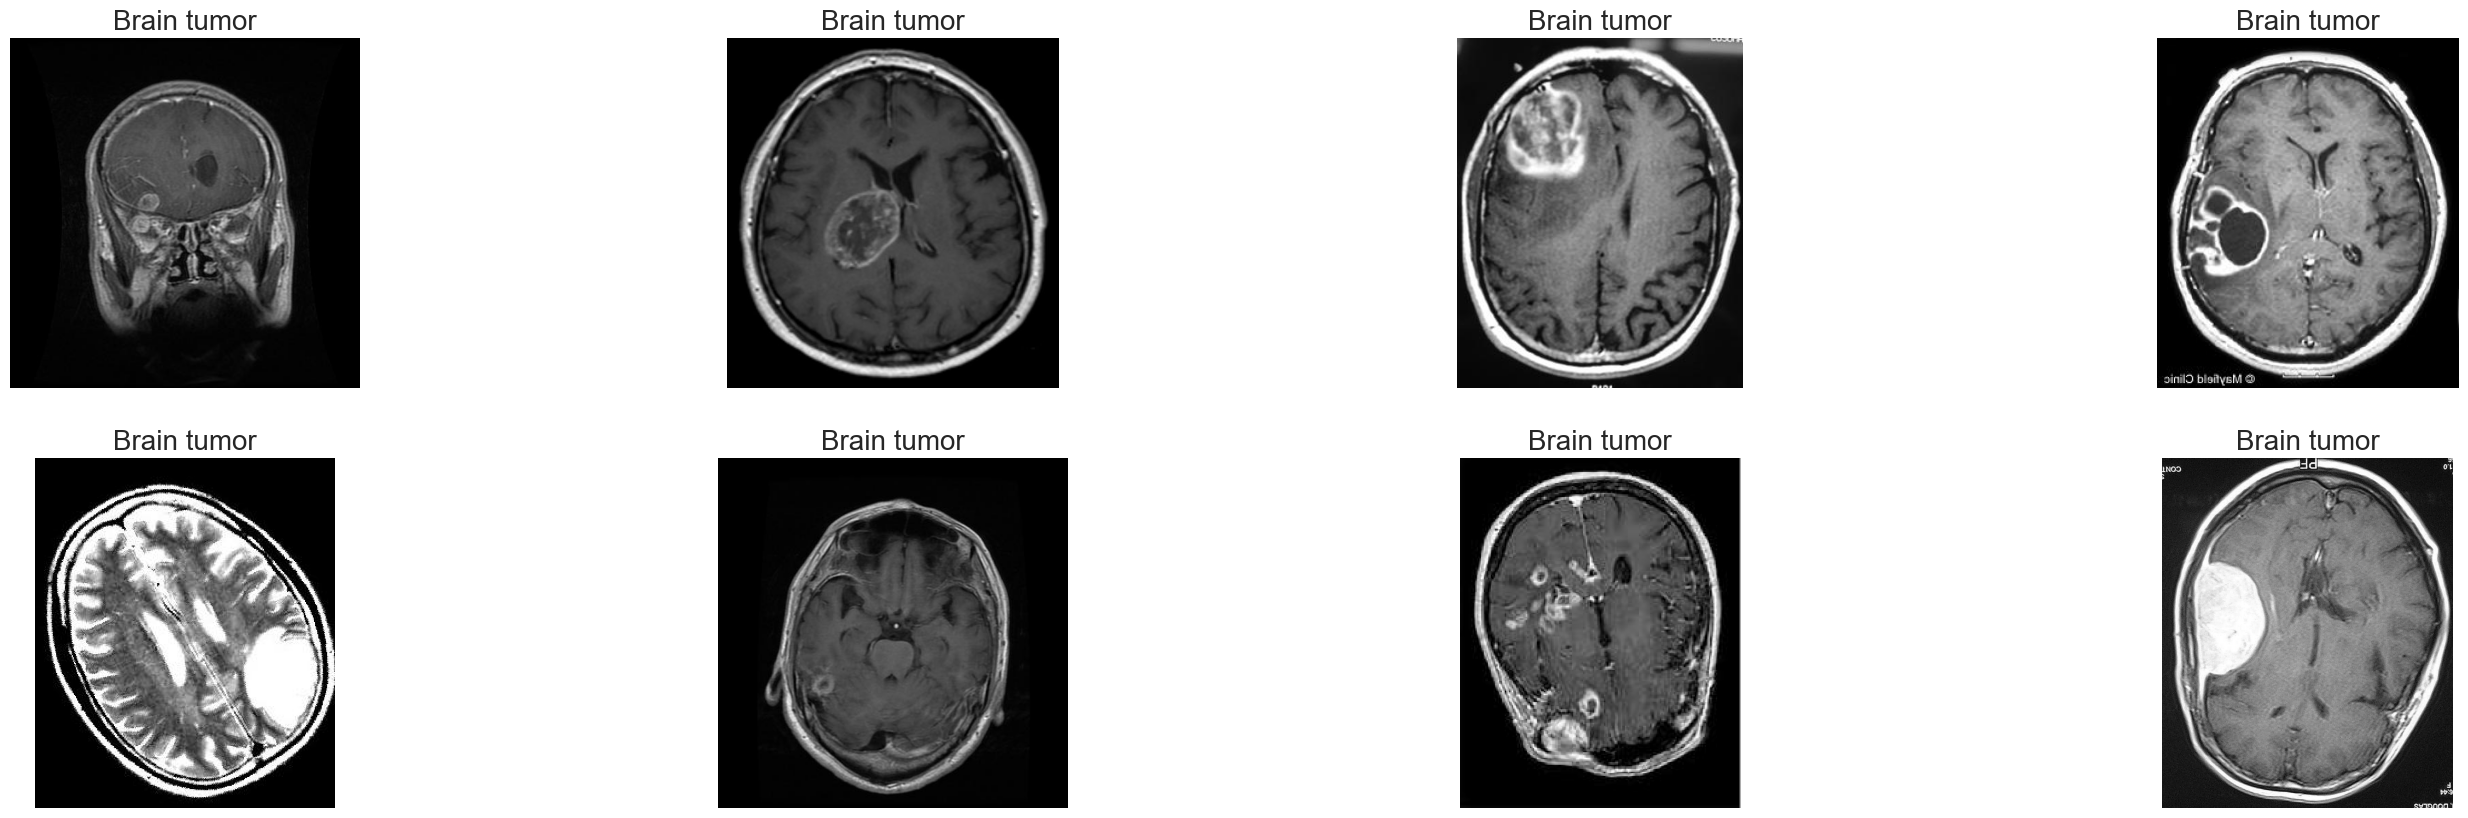

In [6]:
import random

healthy_dir = os.path.join(data_dir, 'train/Healthy')
tumor_dir = os.path.join(data_dir, 'train/Brain Tumor')

healthy_image_paths = [os.path.join(healthy_dir, img) for img in os.listdir(healthy_dir)]
tumor_image_paths = [os.path.join(tumor_dir, img) for img in os.listdir(tumor_dir)]

# Select half from each category
num_images = min(len(healthy_image_paths), len(tumor_image_paths)) // 2
selected_healthy_paths = random.sample(healthy_image_paths, num_images)
selected_tumor_paths = random.sample(tumor_image_paths, num_images)

# Load the selected images into memory
selected_healthy_images = [load_image(img_path) for img_path in selected_healthy_paths]
selected_tumor_images = [load_image(img_path) for img_path in selected_tumor_paths]

# Visualize the selected images
plot_images(selected_healthy_images[:8], ["Healthy"]*8)
plot_images(selected_tumor_images[:8], ["Brain tumor"]*8)

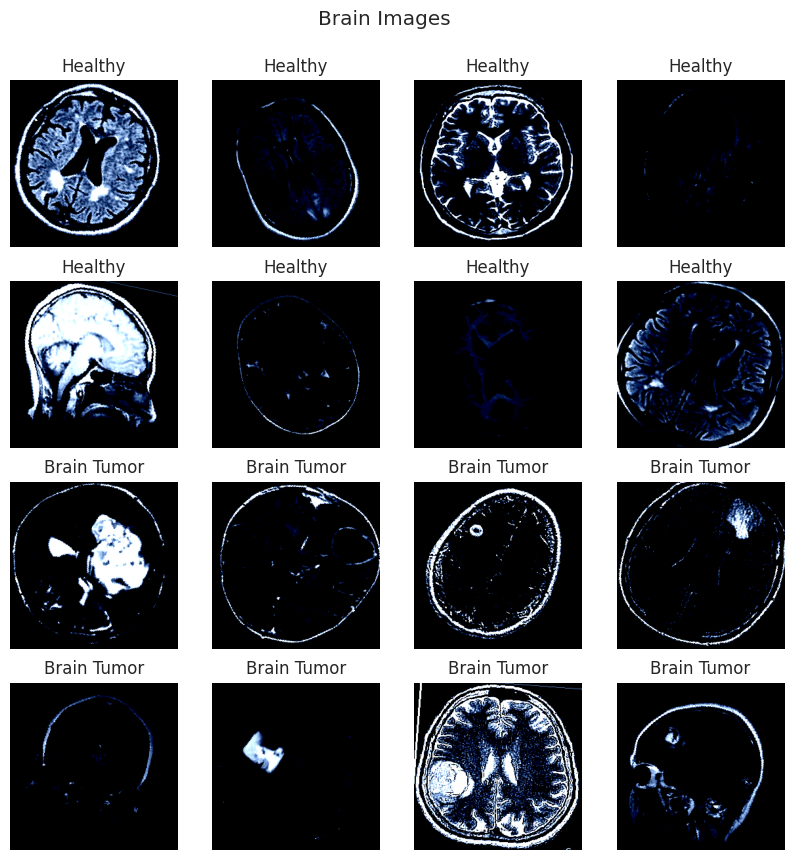

In [8]:
# Visualiztion some images from Train Set, half healthy and half tumor images

########################################
          ### TODO ###
########################################

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b>

In [7]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [76]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Brain Tumor Classifier</b>


In [8]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters. You may not use it in your code'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [9]:
class CNN_TUMOR(nn.Module):
    
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()

        Cin, Hin, Win = params["shape_in"]  # Channels, Height, Width of input
        init_f = params["initial_filters"]  # Initial number of filters for Conv layers
        num_fc1 = params["num_fc1"]         # Number of neurons in the first FC layer
        num_classes = params["num_classes"] # Number of output classes
        self.dropout_rate = params["dropout_rate"]  # Dropout rate

        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, stride=1, padding=1)  # First Conv layer
        self.conv2 = nn.Conv2d(init_f, init_f * 2, kernel_size=3, stride=1, padding=1)  # Second Conv layer
        self.conv3 = nn.Conv2d(init_f * 2, init_f * 4, kernel_size=3, stride=1, padding=1)  # Third Conv layer

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling layer

        # Calculate the size after the conv and pooling layers to flatten
        conv_output_size = self._get_conv_output_size(Hin, Win, init_f * 4)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, num_fc1)  # First fully connected layer
        self.fc2 = nn.Linear(num_fc1, num_classes)  # Output layer

        # Dropout layer
        self.dropout = nn.Dropout(self.dropout_rate)

    def _get_conv_output_size(self, H, W, C_out):
        """ Helper function to calculate the output size after convolution and pooling """
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=1):
            return (size + 2*padding - kernel_size) // stride + 1

        def pool2d_size_out(size, kernel_size=2, stride=2):
            return (size - kernel_size) // stride + 1

        # Apply conv and pool layers to both dimensions (height and width)
        for _ in range(3):  # 3 conv layers with pool after each
            H = conv2d_size_out(H)
            H = pool2d_size_out(H)
            W = conv2d_size_out(W)
            W = pool2d_size_out(W)
        return H * W * C_out

    def forward(self, X):
        # Forward pass through convolutional layers
        X = F.relu(self.conv1(X))
        X = self.pool(X)

        X = F.relu(self.conv2(X))
        X = self.pool(X)

        X = F.relu(self.conv3(X))
        X = self.pool(X)

        # Flatten the output for the fully connected layers
        X = X.view(X.size(0), -1)

        # Fully connected layers with ReLU and Dropout
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)

        return X


In [10]:
# define parameters of the model
params_model = {
    "shape_in": (3, 256, 256),       # 3 input channels (RGB), and image size 256x256
    "initial_filters": 32,           # 32 filters for the first convolutional layer
    "num_fc1": 128,                  # 128 neurons in the first fully connected layer
    "dropout_rate": 0.5,             # 50% dropout rate
    "num_classes": 2                 # 2 classes for binary classification (Healthy, Tumor)
}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b>

In [11]:
# define the loss function

loss_func = nn.CrossEntropyLoss()

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b>

In [12]:
# define the optimizer

opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b>

In [37]:
def loss_batch(loss_func, output, target, opt=None):
    # Calculate the loss
    loss = loss_func(output, target)

    # Compute the metric (accuracy or other metric)
    _, preds = torch.max(output, dim=1)
    corrects = torch.sum(preds == target).item()
    metric_b = corrects / len(target)  # Accuracy for this batch

    # Backward pass and optimizer step (only during training)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, opt=None):
    run_loss = 0.0
    run_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # Model in training or evaluation mode
    is_training = opt is not None
    if is_training:
        model.train()
    else:
        model.eval()

    # Loop over batches in the dataset
    for data, target in dataset_dl:
        data, target = data.to(device), target.to(device)  # Move data to GPU if available

        # Forward pass
        output = model(data)

        # Calculate loss and metric
        loss_b, metric_b = loss_batch(loss_func, output, target, opt)

        # Aggregate the loss and metric
        run_loss += loss_b * len(data)  # Multiply by batch size to scale up
        run_metric += metric_b * len(data)

    # Return the average loss and metric for the entire epoch
    epoch_loss = run_loss / len_data
    epoch_metric = run_metric / len_data

    return epoch_loss, epoch_metric


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b> Training Function</b></p>
</div>


In [38]:
def Train_Val(model, train_dl, val_dl, epochs, opt, lr_scheduler, loss_func):
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}

    # Best model weights (based on validation loss)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # Validation phase
        with torch.no_grad():  # Disable gradient computation for validation
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # Learning rate scheduling
        lr_scheduler.step(val_loss)

        # Print results for this epoch
        print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val accuracy: {100*val_metric:.2f}%")
        print("-" * 10)

        # Save the best model weights
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [39]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [40]:
# Define parameters used for training and evaluation of a cnn_model
epochs = 20

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model, train_loader, val_loader, epochs, opt, lr_scheduler, loss_func)

Epoch 1/20
train loss: 0.3676, val loss: 0.3316, val accuracy: 85.45%
----------
Epoch 2/20
train loss: 0.3402, val loss: 0.3000, val accuracy: 86.10%
----------
Epoch 3/20
train loss: 0.3138, val loss: 0.2766, val accuracy: 88.49%
----------
Epoch 4/20
train loss: 0.2745, val loss: 0.2382, val accuracy: 91.64%
----------
Epoch 5/20
train loss: 0.2568, val loss: 0.2091, val accuracy: 92.18%
----------
Epoch 6/20
train loss: 0.2346, val loss: 0.2027, val accuracy: 91.31%
----------
Epoch 7/20
train loss: 0.2117, val loss: 0.1666, val accuracy: 93.59%
----------
Epoch 8/20
train loss: 0.1943, val loss: 0.1810, val accuracy: 92.29%
----------
Epoch 9/20
train loss: 0.1933, val loss: 0.1611, val accuracy: 93.27%
----------
Epoch 10/20
train loss: 0.1669, val loss: 0.1366, val accuracy: 94.57%
----------
Epoch 11/20
train loss: 0.1615, val loss: 0.1411, val accuracy: 94.68%
----------
Epoch 12/20
train loss: 0.1733, val loss: 0.1224, val accuracy: 95.98%
----------
Epoch 13/20
train loss: 0

## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization </b>

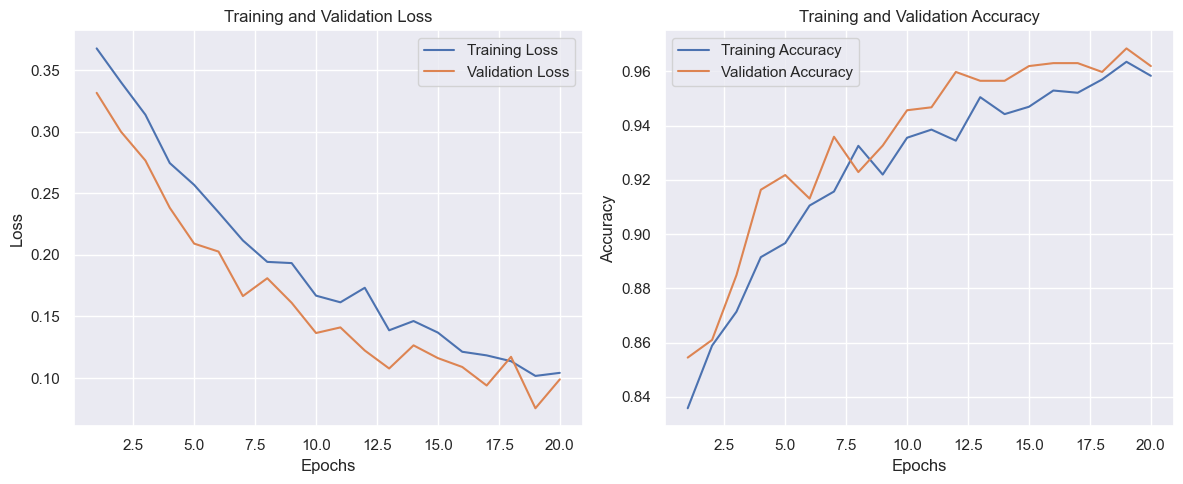

In [42]:
# Convergence History Plot
# plot the loss vlues and accuracy of your model during the training process
def plot_convergence_history(loss_history, metric_history):
    epochs = range(1, len(loss_history["train"]) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    # Plot Loss history
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history["train"], label='Training Loss')
    plt.plot(epochs, loss_history["val"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy history
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metric_history["train"], label='Training Accuracy')
    plt.plot(epochs, metric_history["val"], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_convergence_history(loss_hist, metric_hist)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Confusion_Matrix </b></p>
</div>

In [47]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    model.eval()
    # Disable gradient computation as we're not training
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model output
            output = model(data)
            
            # Get the predicted class (index of the max logit)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Extend the true and predicted lists with the current batch
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy().flatten())
    
    return y_true, y_pred
    
# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       503
           1       0.97      0.96      0.97       418

    accuracy                           0.97       921
   macro avg       0.97      0.97      0.97       921
weighted avg       0.97      0.97      0.97       921
 




In [49]:
def confusion_matrix(y_true, y_pred):
    # Unique classes in the dataset
    num_classes = len(np.unique(y_true))
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        cm[true][pred] += 1  # Increment the appropriate cell
    
    return cm
    
cm = confusion_matrix(y_true, y_pred)

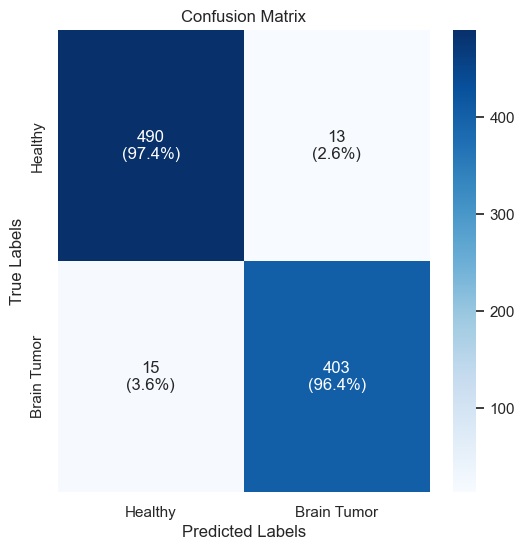

In [57]:
# Confusion Matrix Plotting Function


def show_confusion_matrix(cm, class_names, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    plt.figure(figsize=(6, 6))
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    labels = np.array([[f"{count}\n({percent:.1f}%)" for count, percent in zip(row, perc_row)]
                       for row, perc_row in zip(cm, cm_percent)])
    sns.heatmap(cm, annot=labels, fmt="", plt.colormaps()="Blues", cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

show_confusion_matrix(cm, ["Healthy", "Brain Tumor"])